In [2]:
!pip install medmnist

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple, https://pypi.ngc.nvidia.com


In [3]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

In [4]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.1 @ https://github.com/MedMNIST/MedMNIST/


In [5]:
data_flag = 'breastmnist'
# data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [6]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: /Users/yuqi/.medmnist/breastmnist.npz
Using downloaded and verified file: /Users/yuqi/.medmnist/breastmnist.npz
Using downloaded and verified file: /Users/yuqi/.medmnist/breastmnist.npz


In [7]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset BreastMNIST of size 28 (breastmnist)
    Number of datapoints: 546
    Root location: /Users/yuqi/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'malignant', '1': 'normal, benign'}
    Number of samples: {'train': 546, 'val': 78, 'test': 156}
    Description: The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.
    License: CC BY 4.0
Dataset BreastMNIST of size 28 (breastmnist)
    Number of datapoints: 156
    Root location: /Users/yuqi/.medmnist
    Split: test
    Task: binary-class
    Number of channels: 1
    Meaning

# We first compare their singular values

## We first use standard SVD to check their singular values

In [8]:
from sketching_methods.SVD import standard_svd
svd_standards=[]
singular_values=[]
x_train=[]
y_train=[]
for data in train_dataset:
    x,y=data
    x_train.append(np.array(x[0]))
    y_train.append(np.array(y))
    svd_standard,singular_value=standard_svd(x[0])
    svd_standards.append(svd_standard)
    singular_values.append(singular_value)
    

In [9]:
x_train=np.array(x_train)
y_train=np.array(y_train)

In [10]:
print(x_train.shape)

(546, 28, 28)


In [11]:
svd_standards=np.array(svd_standards)
singular_values=np.array(singular_values)

## then we try our first sketching matrix

In [12]:
!pip install utils

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple, https://pypi.ngc.nvidia.com


## Uniform Sketching Matrices

In [13]:
uniform_matrices=[]
from sketching_methods.sketching import uniform_sketching_matrix
for _ in range (len(train_dataset)):
    uniform_matrix=uniform_sketching_matrix(28, 12)
    uniform_matrices.append(uniform_matrix)


In [14]:
#Turn the matrix into array
uniform_matrices=np.array(uniform_matrices)

In [15]:
#we try to do it in another way
import numpy as np
from scipy.linalg import svd
from numpy.linalg import qr

def randomized_svd(A, k, random_matrix,p=5, n_iter=2):
    """
    Perform Randomized SVD on matrix A.
    
    Parameters:
        A: ndarray, shape (m, n)
           Input matrix to decompose.
        k: int
           Target rank (number of singular values/vectors to compute).
        p: int, optional (default=5)
           Oversampling parameter to improve approximation accuracy.
        n_iter: int, optional (default=2)
           Number of iterations for power iteration (improves accuracy).
           
    Returns:
        U: ndarray, shape (m, k)
           Approximated left singular vectors.
        S: ndarray, shape (k,)
           Approximated singular values.
        V: ndarray, shape (k, n)
           Approximated right singular vectors.
    """
    # Step 1: Random sampling
    A=A.astype(np.float64)
    m, n = A.shape
   
    Y = A @ random_matrix

    # Step 2: Power iteration (optional, improves accuracy for ill-conditioned matrices)
    for _ in range(n_iter):
        Y = A @ (A.T @ Y)

    # Step 3: QR decomposition
    Q, _ = qr(Y, mode='reduced')
    

    # Step 4: Project matrix to lower-dimensional space
    B = Q.T @ A

    # Step 5: Compute SVD on the smaller matrix
    U_tilde, S, Vt = svd(B, full_matrices=False)

    # Step 6: Reconstruct the left singular vectors
    U = Q @ U_tilde

    return U[:, :k], S[:k], Vt[:k, :]


In [16]:
U_randoms=[]
S_randoms=[]
V_randoms=[]
for i in range(len(train_dataset)):
    U_random,S_random,V_random=randomized_svd(x_train[i],12,uniform_matrices[i],3)
    U_randoms.append(U_random)
    S_randoms.append(S_random)
    V_randoms.append(V_random)


In [17]:
U_randoms=np.array(U_randoms)
S_randoms=np.array(S_randoms)
V_randoms=np.array(V_randoms)

In [18]:
#Compute relevant Error
Errors_uniform=[]
for i in range(len(train_dataset)):
    approx_uniform=U_randoms[i]@np.diag(S_randoms[i])@V_randoms[i]
    Errors_uniform.append(np.linalg.norm(approx_uniform-x_train[i],'fro')**2/np.linalg.norm(x_train[i],'fro')**2)


In [19]:
#Errors into nparray
Errors_uniform=np.array(Errors_uniform)

## Gaussian Sketching matrices

In [20]:
gaussian_matrices=[]
from sketching_methods.sketching import gaussian_sketching_matrix
for i in range (len(train_dataset)):
    gaussian_matrix=gaussian_sketching_matrix(28, 12)
    gaussian_matrices.append(gaussian_matrix)

In [21]:
#Turn into nparray
gaussian_matrices=np.array(gaussian_matrices)

In [22]:
# we conduct the same experiment
U_gaussians=[]
S_gaussians=[]
V_gaussians=[]
for i in range(len(train_dataset)):
    U_gaussian,S_gaussian,V_gaussian=randomized_svd(x_train[i],12,gaussian_matrices[i],3)
    U_gaussians.append(U_gaussian)
    S_gaussians.append(S_gaussian)
    V_gaussians.append(V_gaussian)

In [23]:
#turn them into nparray
U_gaussians=np.array(U_gaussians)
S_gaussians=np.array(S_gaussians)
V_gaussians=np.array(V_gaussians)

In [24]:
#Compute relevant Error
Errors_gaussian=[]
for i in range(len(train_dataset)):
    approx_gaussian=U_gaussians[i]@np.diag(S_gaussians[i])@V_gaussians[i]
    Errors_gaussian.append(np.linalg.norm(approx_gaussian-x_train[i],'fro')**2/np.linalg.norm(x_train[i],'fro')**2)


In [25]:
Errors_gaussian=np.array(Errors_gaussian)

## Radamecher Sketching Matrices

In [26]:
rademacher_matrices=[]
from sketching_methods.sketching import rademacher_sketch_matrix
for j in range(len(train_dataset)):
    rademacher_matrix=rademacher_sketch_matrix(28, 12)
    rademacher_matrices.append(rademacher_matrix)
    

In [27]:
#turn it into array
rademacher_matrices=np.array(rademacher_matrices)

In [28]:
# we conduct the same experiment
U_rademachers=[]
S_rademachers=[]
V_rademachers=[]
for i in range(len(train_dataset)):
    U_rademacher,S_rademacher,V_rademacher=randomized_svd(x_train[i],12,rademacher_matrices[i],3)
    U_rademachers.append(U_rademacher)
    S_rademachers.append(S_rademacher)
    V_rademachers.append(V_rademacher)


In [29]:
U_rademachers=np.array(U_rademachers)
S_rademachers=np.array(S_rademachers)
V_rademachers=np.array(V_rademachers)

In [30]:
#Compute relevant Error
Errors_rademacher=[]
for i in range(len(train_dataset)):
    approx_rademacher=U_rademachers[i]@np.diag(S_rademachers[i])@V_rademachers[i]
    Errors_rademacher.append(np.linalg.norm(approx_rademacher-x_train[i],'fro')**2/np.linalg.norm(x_train[i],'fro')**2)

## Johnson-Linderstrauss Transform Code

In [31]:

import sys
import os
sys.path.append(os.path.abspath('.'))


from sketching_methods.jlt.linearMapping import calculate_R
JLT_matrices=[]
for i in range(len(train_dataset)):
    JLT_matrix=calculate_R(28,k=12,s=1,random_seed=21,swr=True)
    JLT_matrices.append(JLT_matrix)



In [32]:
#Turn it into arrays
JLT_matrices=np.array(JLT_matrices)

In [33]:
# we conduct the same experiment to do random SVD
U_JLTs=[]
S_JLTs=[]
V_JLTs=[]
for i in range(len(train_dataset)):
    U_JLT,S_JLT,V_JLT=randomized_svd(x_train[i],12,JLT_matrices[i].toarray().T,3)
    U_JLTs.append(U_JLT)
    S_JLTs.append(S_JLT)
    V_JLTs.append(V_JLT)



In [34]:
U_JLTs=np.array(U_JLTs)
S_JLTs=np.array(S_JLTs)
V_JLTs=np.array(V_JLTs)

In [35]:
#Compute relevant Error
Errors_JLT=[]
for i in range(len(x_train)):
    approx_JLT=U_JLTs[i]@np.diag(S_JLTs[i])@V_JLTs[i]
    Errors_JLT.append(np.linalg.norm(approx_JLT-x_train[i],'fro')**2/np.linalg.norm(x_train[i],'fro')**2)

In [36]:
#Turn it into an array
Errors_JLT=np.array(Errors_JLT)

## Clarkson_Woodruff

In [37]:
from sketching_methods.sketching import cwt_sketch_matrix
cwt_sketch_matrices=[]
for _ in range(len(train_dataset)):
    cwt_matrix=cwt_sketch_matrix(28,12,rng=None)
    cwt_sketch_matrices.append(cwt_matrix)

In [38]:
# we conduct the same experiment to do random SVD
U_cwts=[]
S_cwts=[]
V_cwts=[]
for i in range(len(train_dataset)):
    U_cwt,S_cwt,V_cwt=randomized_svd(x_train[i],12,cwt_sketch_matrices[i],3)
    U_cwts.append(U_cwt)
    S_cwts.append(S_cwt)
    V_cwts.append(V_cwt)


In [39]:
U_cwts=np.array(U_cwts)
S_cwts=np.array(S_cwts)
V_cwts=np.array(V_cwts)

In [40]:
#Compute Relative Error
Errors_cwt=[]
for i in range(len(train_dataset)):
    approx_cwt=U_cwts[i]@np.diag(S_cwts[i])@V_cwts[i]
    Errors_cwt.append(np.linalg.norm(approx_cwt-x_train[i],'fro')**2/np.linalg.norm(x_train[i],'fro')**2)

In [41]:
Errors_cwt=np.array(Errors_cwt)

## LESS Transform

In [42]:
#Another kind of calculation
def randomized_SVD_without_power_iteration(Y,A,k):
    Q, _ = qr(Y, mode='reduced')
    

    # Step 4: Project matrix to lower-dimensional space
    B = Q.T @ A

    # Step 5: Compute SVD on the smaller matrix
    U_tilde, S, Vt = svd(B, full_matrices=False)

    # Step 6: Reconstruct the left singular vectors
    U = Q @ U_tilde

    return U[:, :k], S[:k], Vt[:k, :]


## SRFT Transform

In [43]:
#SJLT Transform
SRFT_matrices=[]
from sketching_methods.sketching  import SRFT_real_sketch_matrix

for _ in range(len(train_dataset)):
    SRFT_matrix=SRFT_real_sketch_matrix(12,28)
    SRFT_matrices.append(SRFT_matrix)
SRFT_matrices=np.array(SRFT_matrices)



In [44]:
U_SRFTs=[]
S_SRFTs=[]
V_SRFTs=[]
for i in range(len(train_dataset)):
    U_SRFT,S_SRFT,V_SRFT=randomized_svd(x_train[i],12,SRFT_matrices[i].T,3)
    U_SRFTs.append(U_SRFT)
    S_SRFTs.append(S_SRFT)
    V_SRFTs.append(V_SRFT)
U_SRFTs=np.array(U_SRFTs)
S_SRFTs=np.array(S_SRFTs)
V_SRFTs=np.array(V_SRFTs)


In [45]:
#Compute Relative Error
#Compute Relative Error
Errors_SRFTs=[]
for i in range(len(train_dataset)):
    approx_SRFT=U_SRFTs[i]@np.diag(S_SRFTs[i])@V_SRFTs[i]
    Errors_SRFTs.append(np.linalg.norm(approx_SRFT-x_train[i],'fro')**2/np.linalg.norm(x_train[i],'fro')**2)

## SSE

In [46]:
#SJLT Transform
SSE_matrices=[]
from sketching_methods.sketching  import sparse_sign_embedding_sketch_matrix

for _ in range(len(train_dataset)):
    SSE_matrix=sparse_sign_embedding_sketch_matrix(12,28)
    SSE_matrices.append(SSE_matrix)
SSE_matrices=np.array(SSE_matrices)
U_SSEs=[]
S_SSEs=[]
V_SSEs=[]
for i in range(len(train_dataset)):
    U_SSE,S_SSE,V_SSE=randomized_svd(x_train[i],12,SSE_matrices[i].T,3)
    U_SSEs.append(U_SSE)
    S_SSEs.append(S_SSE)
    V_SSEs.append(V_SSE)
U_SSEs=np.array(U_SSEs)
S_SSEs=np.array(S_SSEs)
V_SSEs=np.array(V_SSEs)
#Compute Relative Error
#Compute Relative Error
Errors_SSEs=[]
for i in range(len(train_dataset)):
    approx_SSE=U_SSEs[i]@np.diag(S_SSEs[i])@V_SSEs[i]
    Errors_SSEs.append(np.linalg.norm(approx_SSE-x_train[i],'fro')**2/np.linalg.norm(x_train[i],'fro')**2)


## Orthogonal Random Matrices

In [47]:
#SJLT Transform
orthogonal_randoms=[]
from utilities.helpers  import get_random_orth_matrix

for _ in range(len(train_dataset)):
    orthogonal_random=get_random_orth_matrix(12,28)
    orthogonal_randoms.append(orthogonal_random)
orthogonal_randoms=np.array(orthogonal_randoms)
U_othos=[]
S_othos=[]
V_othos=[]
for i in range(len(train_dataset)):
    U_otho,S_otho,V_otho=randomized_svd(x_train[i],12,SSE_matrices[i].T,3)
    U_othos.append(U_otho)
    S_othos.append(S_otho)
    V_othos.append(V_otho)
U_othos=np.array(U_othos)
S_othos=np.array(S_othos)
V_othos=np.array(V_othos)
#Compute Relative Error
#Compute Relative Error
Errors_othos=[]
for i in range(len(train_dataset)):
    approx_otho=U_othos[i]@np.diag(S_othos[i])@V_othos[i]
    Errors_othos.append(np.linalg.norm(approx_otho-x_train[i],'fro')**2/np.linalg.norm(x_train[i],'fro')**2)

## Standard SVD

In [56]:
# Let's check their condition number
Condition_number=[]
result_svd=[]
for i in range(len(x_train)):
    S,V,D=svd(x_train[i],full_matrices=False)
    approx_svd=S[:,:12]@np.diag(V[:12])@D[:12,:]
    result_svd.append(approx_svd)
    condition=V[0]/V[-1]
    Condition_number.append(condition)
Errors_svd=[]
for i in range(len(train_dataset)):
    Errors_svd.append(np.linalg.norm(result_svd[i]-x_train[i],'fro')**2/np.linalg.norm(x_train[i],'fro')**2)

# Visualization

In [58]:
# Combine all those relative errors that we computed
errors=np.vstack((Errors_uniform,Errors_gaussian,Errors_rademacher,Errors_JLT,Errors_cwt,Errors_SSEs,Errors_othos,Errors_svd)).T

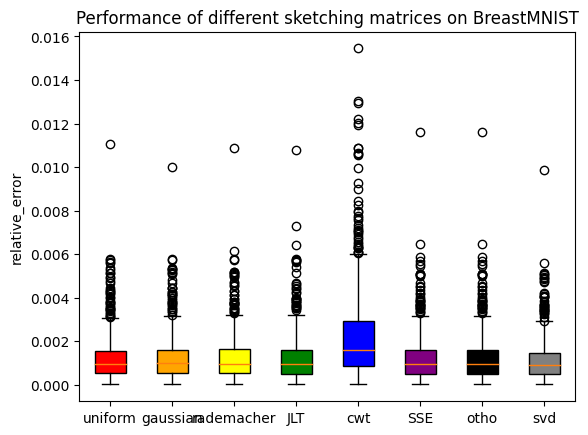

In [59]:
#We try to do some boxplots
#Considering relevant Error
import matplotlib.pyplot as plt
labels=['uniform','gaussian','rademacher','JLT','cwt','SSE','otho','svd']
colors=['red','orange','yellow','green','blue','purple','black','grey']
fig,ax=plt.subplots()
ax.set_ylabel('relative_error')
ax.set_title('Performance of different sketching matrices on BreastMNIST')
bplot=ax.boxplot(errors, patch_artist=True,labels=labels)

for patch, color in zip(bplot['boxes'],colors):
    patch.set_facecolor(color)
plt.show()

In [60]:
##Check more metric
import pandas as pd
df_describe=pd.DataFrame(errors)
df_describe.describe()

,0,1,2,3,4,5,6,7
count,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000
mean,0.001260,0.001264,0.001272,0.001274,0.002311,0.001269,0.001269,0.001163
std,0.001126,0.001112,0.001129,0.001154,0.002216,0.001139,0.001139,0.001032
min,0.000019,0.000019,0.000020,0.000019,0.000025,0.000020,0.000020,0.000019
25%,0.000527,0.000524,0.000528,0.000513,0.000859,0.000519,0.000519,0.000486
50%,0.000975,0.000987,0.000969,0.000980,0.001595,0.000965,0.000965,0.000908
75%,0.001566,0.001587,0.001632,0.001619,0.002912,0.001615,0.001615,0.001470
max,0.011040,0.010014,0.010873,0.010772,0.015447,0.011631,0.011631,0.009848


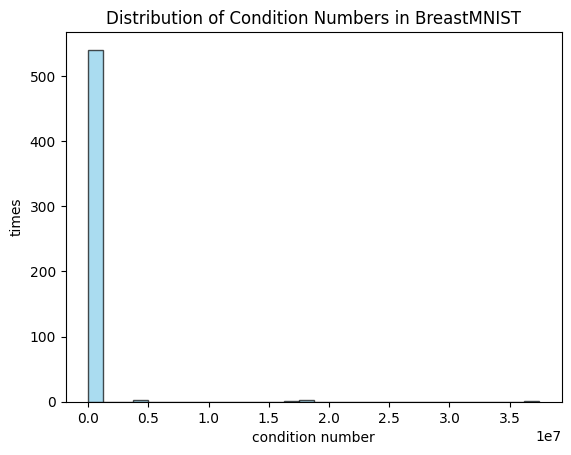

In [52]:
plt.hist(Condition_number, bins=30, color='skyblue', edgecolor='black', alpha=0.7)

# 添加标题和标签
plt.title('Distribution of Condition Numbers in BreastMNIST')
plt.xlabel('condition number')
plt.ylabel('times')

# 显示图形
plt.show()


In [53]:
print('mean',np.mean(Condition_number))
print('median',np.median(Condition_number))         # 中位数
print('std',np.std(Condition_number))           # 标准差
print('var',np.var(Condition_number))          # 方差
print('min',np.min(Condition_number))           # 最小值
print('max',np.max(Condition_number))           # 最大值
print('percentile',np.percentile(Condition_number, [25, 50, 75]))  # 四分位数

mean 214174.42
median 7550.501
std 2092977.5
var 4380555000000.0
min 647.31476
max 37453104.0
percentile [ 3532.62408447  7550.50073242 19286.70947266]


In [54]:
np.min(Condition_number)

647.31476

In [55]:
np.max(Condition_number)

37453104.0